In [3]:
# Installing dependencies 

import os, json, time, threading, queue
import numpy as np
import sounddevice as sd
import soundfile as sf
import librosa
import cv2
import matplotlib.pyplot as plt
import onnxruntime as ort
from IPython.display import Audio, clear_output

In [4]:
# Configuration

# Audio & feature extraction
SAMPLE_RATE = 16000
CHUNK_SEC   = 1.0
N_FFT       = 1024
HOP_LEN     = 256
N_MELS      = 64
IMG_SIZE    = 224

# Model config
NORMALIZE_MODE = 'tf'      # 'tf' for [-1,1], 'torch' for ImageNet mean/std
INPUT_LAYOUT   = 'NHWC'    # 'NHWC' for TF/TFLite, 'NCHW' for PyTorch
MODEL_PATH     = 'models/model.onnx'   # change to your model path

# Detection
THRESHOLD = 0.6
EVENT_DIR = 'events'
os.makedirs(EVENT_DIR, exist_ok=True)

In [5]:
# Audio capturing

CHUNK_SIZE = int(SAMPLE_RATE * CHUNK_SEC)
audio_q = queue.Queue(maxsize=8)
stop_flag = threading.Event()

def _audio_cb(indata, frames, time_info, status):
    if status:
        print('Audio status:', status)
    try:
        audio_q.put_nowait(indata[:,0].copy())  
    except queue.Full:
        pass

stream = None

def start_audio():
    global stream
    stop_flag.clear()
    stream = sd.InputStream(samplerate=SAMPLE_RATE, channels=1, dtype='float32',
                            blocksize=CHUNK_SIZE, callback=_audio_cb)
    stream.start()
    print("Audio stream started.")

def stop_audio():
    global stream
    stop_flag.set()
    if stream:
        stream.stop(); stream.close()
        stream = None
    print("Audio stream stopped.")


In [6]:
# Mel spectogram

def melspec_3ch(y, sr):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT,
                                         hop_length=HOP_LEN, n_mels=N_MELS, power=2.0)
    logmel = librosa.power_to_db(mel, ref=np.max)
    d1 = librosa.feature.delta(logmel)
    d2 = librosa.feature.delta(logmel, order=2)

    img = np.stack([logmel, d1, d2], axis=-1)  # (n_mels, time, 3)

    mn = img.min(axis=(0,1), keepdims=True)
    mx = img.max(axis=(0,1), keepdims=True)
    img01 = (img - mn) / (mx - mn + 1e-9)

    img01 = cv2.resize(img01.astype(np.float32), (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

    if NORMALIZE_MODE == 'tf':
        img_norm = img01 * 2 - 1
    elif NORMALIZE_MODE == 'torch':
        mean = np.array([0.485,0.456,0.406], np.float32)
        std  = np.array([0.229,0.224,0.225], np.float32)
        img_norm = (img01 - mean) / std
    else:
        img_norm = img01

    if INPUT_LAYOUT == 'NHWC':
        return img_norm[None,...].astype(np.float32)
    else:
        return np.transpose(img_norm, (2,0,1))[None,...].astype(np.float32)

In [7]:
import os
os.makedirs("models", exist_ok=True)

# Download MobileNetV2 ONNX model using curl
!curl -L https://github.com/onnx/models/raw/main/vision/classification/mobilenet/model/mobilenetv2-7.onnx -o models/model.onnx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  284k    0  284k    0     0   491k      0 --:--:-- --:--:-- --:--:--  494k


In [8]:
def softmax(z):
    z = z - np.max(z)
    e = np.exp(z)
    return e / np.sum(e)

def fake_inference(x):
    # Pretend we have 5 classes
    probs = np.random.rand(5)
    return probs / np.sum(probs)

In [9]:
# Process & detect

def worker_loop():
    i = 0
    while not stop_flag.is_set():
        try:
            y = audio_q.get(timeout=0.5)
        except queue.Empty:
            continue

        x = melspec_3ch(y, SAMPLE_RATE)
        probs = fake_inference(x)
        cls = int(np.argmax(probs))
        conf = float(np.max(probs))

        print(f"chunk {i}: cls={cls}, conf={conf:.3f}")

        if conf >= THRESHOLD:
            ts = int(time.time())
            wav_path = f"{EVENT_DIR}/event_{ts}_{i}.wav"
            sf.write(wav_path, y, SAMPLE_RATE)
            meta = {"time": ts, "chunk": i, "class": cls, "conf": conf, "wav": wav_path}
            json.dump(meta, open(f"{EVENT_DIR}/event_{ts}_{i}.json", "w"))

        i += 1

In [10]:
# Running

# Start processing
worker_thread = threading.Thread(target=worker_loop, daemon=True)
start_audio()
worker_thread.start()

Audio stream started.
chunk 0: cls=3, conf=0.302
chunk 1: cls=0, conf=0.264
chunk 2: cls=1, conf=0.293
chunk 3: cls=0, conf=0.392
chunk 4: cls=1, conf=0.394
chunk 5: cls=1, conf=0.353
chunk 6: cls=0, conf=0.259
chunk 7: cls=2, conf=0.505
chunk 8: cls=3, conf=0.356
chunk 9: cls=4, conf=0.334
chunk 10: cls=3, conf=0.409
chunk 11: cls=2, conf=0.290
chunk 12: cls=3, conf=0.350
chunk 13: cls=1, conf=0.332
chunk 14: cls=2, conf=0.547


In [11]:
stop_audio()

Audio stream stopped.


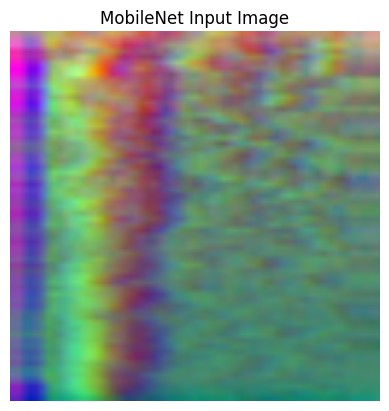

In [12]:
# Testing

rec = sd.rec(int(SAMPLE_RATE*CHUNK_SEC), samplerate=SAMPLE_RATE, channels=1, dtype='float32')
sd.wait()
x = melspec_3ch(rec[:,0], SAMPLE_RATE)
plt.imshow((x[0] - x[0].min()) / (x[0].max() - x[0].min() + 1e-9))
plt.title("MobileNet Input Image")
plt.axis('off')
plt.show()

# Data & Feedback Handling – Local Buffering

In [13]:
import time
from collections import deque

# Buffer to store recent detections
# Each entry: { 'prediction': ..., 'confidence': ..., 'model_version': ..., 'timestamp': ... }
detection_buffer = deque(maxlen=100)  # keeping the last 100 detections

def add_detection(prediction, confidence, model_version="MobileNet_v1"):
    entry = {
        "prediction": prediction,
        "confidence": confidence,
        "model_version": model_version,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    }
    detection_buffer.append(entry)
    return entry

# Data & Feedback Handling - Confidence-based Misclassification/Unclear Sample Handling

In [14]:
# Cache for uncertain/misclassified samples
uncertain_cache = []

# Thresholds for confidence
LOW_CONFIDENCE_THRESHOLD = 0.5  

def handle_uncertain_samples(prediction, confidence, sample):
    if confidence < LOW_CONFIDENCE_THRESHOLD:
        uncertain_cache.append({
            "sample": sample,
            "prediction": prediction,
            "confidence": confidence,
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        })
        print(f"⚠️ Cached uncertain sample (confidence={confidence:.2f}) for review.")

# User and Alert Management - Basic alert system

In [15]:
# Basic alert system
def send_alert(event_message, method="console"):
    if method == "console":
        print(f"🔔 ALERT: {event_message}")
    elif method == "file":
        with open("alerts.log", "a") as f:
            f.write(f"{time.strftime('%Y-%m-%d %H:%M:%S')} - {event_message}\n")

# User and Alert Management - User Notification Preferences

In [16]:
# Example user notification settings
user_preferences = {
    "notify_method": "console"  # options: "console", "file"
}

def notify_user(event_message):
    method = user_preferences.get("notify_method", "console")
    send_alert(event_message, method)

In [18]:
import random
import time
from collections import deque

# ==============================
# 1. Local Buffering
# ==============================
detection_buffer = deque(maxlen=5)  # keeping last 5 detections

def add_detection(prediction, confidence, model_version="MobileNet_v1"):
    entry = {
        "prediction": prediction,
        "confidence": confidence,
        "model_version": model_version,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    }
    detection_buffer.append(entry)
    print(f"✅ Added to buffer: {entry}")
    return entry

# ==============================
# 2. Handling Uncertain Samples
# ==============================
uncertain_cache = []
LOW_CONFIDENCE_THRESHOLD = 0.5

def handle_uncertain_samples(prediction, confidence, sample):
    if confidence < LOW_CONFIDENCE_THRESHOLD:
        uncertain_cache.append({
            "sample": sample,
            "prediction": prediction,
            "confidence": confidence,
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        })
        print(f"⚠️ Cached uncertain sample: {sample}, confidence={confidence:.2f}")

# ==============================
# 3. Simple Alert System
# ==============================
def send_alert(event_message, method="console"):
    if method == "console":
        print(f"🔔 ALERT: {event_message}")
    elif method == "file":
        with open("alerts.log", "a") as f:
            f.write(f"{time.strftime('%Y-%m-%d %H:%M:%S')} - {event_message}\n")

# ==============================
# 4. User Notification Preferences
# ==============================
user_preferences = {
    "notify_method": "console"  # options: "console", "file"
}

def notify_user(event_message):
    method = user_preferences.get("notify_method", "console")
    send_alert(event_message, method)

# ==============================
# 5. Testing with Fake Predictions
# ==============================
labels = ["angry", "calm", "happy", "sad"]

print("\n--- Running Test ---")
for i in range(7):  # simulating 7 predictions
    sample = f"sample_{i}.wav"
    prediction = random.choice(labels)
    confidence = round(random.uniform(0.2, 0.95), 2)  # random confidence between 0.2 and 0.95
    
    # Step 1: store detection
    add_detection(prediction, confidence)
    
    # Step 2: check for uncertain samples
    handle_uncertain_samples(prediction, confidence, sample)
    
    # Step 3: trigger alert if confidence is too low
    if confidence < LOW_CONFIDENCE_THRESHOLD:
        notify_user(f"Low confidence ({confidence:.2f}) for {sample}")

print("\n--- Final Buffers ---")
print("Detection Buffer:", list(detection_buffer))
print("Uncertain Cache:", uncertain_cache)


--- Running Test ---
✅ Added to buffer: {'prediction': 'calm', 'confidence': 0.68, 'model_version': 'MobileNet_v1', 'timestamp': '2025-09-14 22:40:43'}
✅ Added to buffer: {'prediction': 'sad', 'confidence': 0.74, 'model_version': 'MobileNet_v1', 'timestamp': '2025-09-14 22:40:43'}
✅ Added to buffer: {'prediction': 'happy', 'confidence': 0.83, 'model_version': 'MobileNet_v1', 'timestamp': '2025-09-14 22:40:43'}
✅ Added to buffer: {'prediction': 'sad', 'confidence': 0.52, 'model_version': 'MobileNet_v1', 'timestamp': '2025-09-14 22:40:43'}
✅ Added to buffer: {'prediction': 'happy', 'confidence': 0.39, 'model_version': 'MobileNet_v1', 'timestamp': '2025-09-14 22:40:43'}
⚠️ Cached uncertain sample: sample_4.wav, confidence=0.39
🔔 ALERT: Low confidence (0.39) for sample_4.wav
✅ Added to buffer: {'prediction': 'happy', 'confidence': 0.51, 'model_version': 'MobileNet_v1', 'timestamp': '2025-09-14 22:40:43'}
✅ Added to buffer: {'prediction': 'calm', 'confidence': 0.64, 'model_version': 'Mobil

In [19]:
import pandas as pd

df = pd.DataFrame(list(detection_buffer))
df.to_csv("output.csv", index=False)